In [1]:
import pandas as pd
import seaborn as sns
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d

In [32]:
color_names = []
for j in mcolors.CSS4_COLORS:
    color_names.append(j)

In [33]:
import json

with open('../data/result_032020.json', 'r') as JSON:
    json_dict = json.load(JSON)
data = json.loads(json_dict)    

In [34]:
data.keys()

dict_keys(['Image_index', 'Filter_name', 'count', 'Filter_parameter', 'time', 'ROC'])

In [35]:
energy = np.array(data['ROC']['energy'])[range(0,200,2), :, :]
time = np.array(data['time']).reshape(energy.shape[2],energy.shape[0])
energy_mean = energy.mean(axis=0)
energy_std = energy.std(axis=0)

### Calculating AUC of ROC's

In [36]:
curves = np.array(data['ROC']['array'])
curves.shape

(200, 2, 121, 155)

In [37]:
sg_eff = curves[range(0,200,2),0,:,:]
bg_eff = curves[range(0,200,2),1,:,:]

In [38]:
sg_eff_mean, bg_eff_mean = sg_eff.mean(axis = 0), bg_eff.mean(axis = 0)
sg_eff_std, bg_eff_std = sg_eff.std(axis = 0), bg_eff.std(axis = 0)

In [39]:
names = data['Filter_name'][0:155]
params = data['Filter_parameter'][0:155]

In [40]:
auc_mean = (abs(np.diff(sg_eff_mean, axis = 0))*bg_eff_mean[1:,:]).sum(axis = 0)
print(names[auc_mean.argmax()] + ' - ' + 'params' + str(params[auc_mean.argmax()]))
f1_scores = ((2*sg_eff_mean*bg_eff_mean)/(sg_eff_mean+bg_eff_mean))
f1_best_scores = f1_scores.max(axis=0)

nlmeans - params[1, 11]


In [41]:
f1_scores_all = ((2*sg_eff*bg_eff)/(sg_eff+bg_eff))
f1_score_best_per_image = f1_scores_all.max(axis=1)
f1_score_best_per_image.shape

(100, 155)

FCAIDE: 
[0]-0.862+0.05- 1450432053- sg (%) : 0.5657606781267778 - energy :100.97450967440085
bilateral: 
[7, 1, 9]-0.796+0.05- 795322778- sg (%) : 0.3960777415951289 - energy :712.5389963834909
bm3D: 
[3]-0.817+0.05- 1408052473- sg (%) : 0.4664692625202007 - energy :276.1117815657754
gaussian: 
[7]-0.825+0.05- 533737169- sg (%) : 0.4593241137843104 - energy :535.7960266618522
mean: 
[7]-0.797+0.05- 1229108127- sg (%) : 0.39127503072454584 - energy :748.8668820041695
median: 
[7]-0.800+0.04- 1276664024- sg (%) : 0.35588200730936703 - energy :878.1607946540257
nlmeans: 
[11, 7]-0.823+0.05- 862552388- sg (%) : 0.4412522727967679 - energy :385.3507115356368
wiener: 
[1]-0.781+0.04- 993699011- sg (%) : 0.37873460191334973 - energy :527.9211041874721
None: [1]-0.687+0.02- 993699011- sg (%) : 0.19746864280685955- en : 111.68067794402297


Text(0.5, 1.0, 'ROC curve')

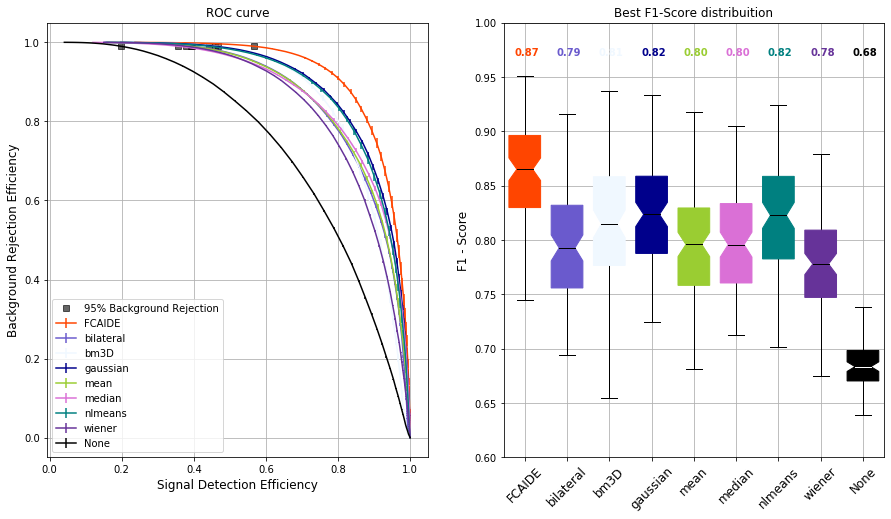

In [42]:
np.random.seed(3)
fig,ax = plt.subplots(1,2, figsize=(15,8))
filter_names = np.unique(names)
colors_index = np.random.randint(low=0, high=len(color_names), size=len(filter_names))
best_times = []
ind_none = np.where((np.array(names)=='mean'))[0][0]
for i,filter_name in list(enumerate(filter_names)):
    index = np.where(filter_name == np.array(names))[0]
    best_index = index[f1_best_scores[index].argmax()]
    best_time = time[best_index, :].astype(np.int64).mean()
    c = color_names[colors_index[i]]
    ax[0].errorbar(sg_eff_mean[:, best_index], 
                 bg_eff_mean[:, best_index],
                 yerr = bg_eff_std[:, best_index]/np.sqrt(100),
                 label = names[best_index],
                 color = c)
    ax[1].boxplot(f1_score_best_per_image[:, best_index], 
                  positions = [i],
                  patch_artist=True,
                  notch = True,
                  boxprops=dict(facecolor=c, color=c),
                  capprops=dict(color='black'),
                  whiskerprops=dict(color='black'),
                  flierprops=dict(color='black', markeredgecolor='black'),
                  medianprops=dict(color='black'),
                  widths = 0.75)
    ax[1].text(i-0.25, 0.97, 
               str('%.2f'%np.median(f1_score_best_per_image[:, best_index])),
               color = c,
               fontweight = 'black')
    #ax[1].set_xlim(-0.5, 7.5)
    ## plot points
    f_sg_bg = interp1d(sg_eff_mean[:, best_index], bg_eff_mean[:, best_index])
    f_bg_sg = interp1d(bg_eff_mean[:, best_index], sg_eff_mean[:, best_index])

    f_sg_en = interp1d(sg_eff_mean[:, best_index], abs(energy_mean[:, best_index]))
    sg_detection = f_bg_sg(0.99)
    ax[0].plot(sg_detection, 0.99, 'sk', alpha = 0.6)
    print(filter_name + ': \n' + 
          str(params[best_index]) + 
          '-' + 
          str('%.3f'%np.mean(f1_score_best_per_image[:, best_index])) + 
          '+' + 
          str('%.2f'%np.std(f1_score_best_per_image[:, best_index])) + 
          '- ' + 
          str(int(best_time)) + 
          '- sg (%) : ' + 
          str(sg_detection) +
          " - energy :" +
          str(f_sg_en(sg_detection)))

    
    

ax[0].errorbar(sg_eff_mean[:, ind_none], 
               bg_eff_mean[:, ind_none],
               yerr = bg_eff_std[:, ind_none]/np.sqrt(100),
               label = 'None',
               color = 'black')
ax[1].boxplot(f1_score_best_per_image[:, ind_none], 
              positions = [i+1],
              patch_artist=True,
              notch = True,
              boxprops=dict(facecolor='black', color='black'),
              capprops=dict(color='black'),
              whiskerprops=dict(color='black'),
              flierprops=dict(color='black', markeredgecolor='black'),
              medianprops=dict(color='white'),
              widths = 0.75)
ax[1].text(i+1-0.25, 0.97, 
               str('%.2f'%np.median(f1_score_best_per_image[:, ind_none])),
               color = 'black',
               fontweight = 'black')

f_sg_bg = interp1d(sg_eff_mean[:, ind_none], bg_eff_mean[:, ind_none])
f_bg_sg = interp1d(bg_eff_mean[:, ind_none], sg_eff_mean[:, ind_none])
f_sg_en = interp1d(sg_eff_mean[:, ind_none], abs(energy_mean[:, ind_none]))
print('None' + ': ' + 
      str(params[ind_none]) +
      '-' + 
      str('%.3f'%np.mean(f1_score_best_per_image[:, ind_none])) +
      '+' + 
      str('%.2f'%np.std(f1_score_best_per_image[:, ind_none])) +
      '- ' + 
      str(int(best_time)) + 
      '- sg (%) : ' + 
      str(f_bg_sg(0.99)) +
      '- en : '+
      str(f_sg_en(sg_detection)))

ax[0].plot(f_bg_sg(0.99),0.99, 'sk', alpha = 0.6, label = '95% Background Rejection')

#ax[1].set_xticks(range(0, len(filter_names), filter_names)
ax[0].set_xlabel('Signal Detection Efficiency', fontsize=12)
ax[0].set_ylabel('Background Rejection Efficiency', fontsize=12)
ax[0].grid()
ax[0].legend()  
ax[1].grid()
#ax[1].set_xticks(range(0, len(filter_names), list(filter_names)))
ax[1].set_xticklabels(np.append(filter_names,'None'),
                    rotation=45, fontsize=12)
ax[1].set_ylim(0.6, 1.)
ax[1].set_ylabel('F1 - Score', fontsize=12)
ax[1].set_title('Best F1-Score distribuition')
ax[0].set_title('ROC curve')

In [43]:
n_pixels_mean = np.array(data['count']).astype(np.int).mean()
print("Número médio de pixels de sinal : " + str(n_pixels_mean))

Número médio de pixels de sinal : 830.06


In [44]:
n_pixels_total = 512*512
print("Número total de pixels de background" + str(n_pixels_total))

Número total de pixels de background262144


## Plot energy

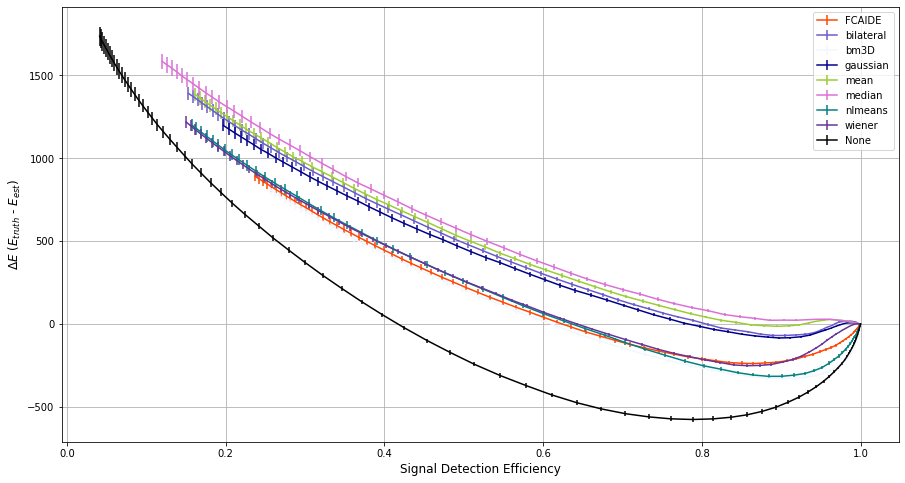

In [15]:
np.random.seed(3)
fig,ax = plt.subplots(1,1, figsize=(15,8))
filter_names = np.unique(names)
colors_index = np.random.randint(low=0, high=len(color_names), size=len(filter_names))
best_times = []
ind_none = np.where((np.array(names)=='mean'))[0][0]
for i,filter_name in list(enumerate(filter_names)):
    index = np.where(filter_name == np.array(names))[0]
    best_index = index[f1_best_scores[index].argmax()]
    best_time = time[best_index, :].astype(np.int64).mean()
    c = color_names[colors_index[i]]
    ax.errorbar(sg_eff_mean[:, best_index], 
                 energy_mean[:, best_index],
                 yerr = energy_std[:, best_index]/np.sqrt(100),
                 label = names[best_index],
                 color = c)
    
    #ax[1].set_xlim(-0.5, 7.5)
    ## plot points
    f_sg_bg = interp1d(sg_eff_mean[:, best_index], bg_eff_mean[:, best_index])
    f_sg_en = interp1d(sg_eff_mean[:, best_index], abs(energy_mean[:, best_index]))
    #ax[0].plot(0.9, f_sg_bg(0.9), 'sk', alpha = 0.6)
    #print(filter_name + ': ' + str(params[best_index]) + '-' + str('%.3f'%np.mean(f1_score_best_per_image[:, best_index])) + '+' + str('%.2f'%np.std(f1_score_best_per_image[:, best_index])) + '- ' + str(int(best_time)) + '- Background Detection : ' + str(1-f_sg_bg(0.9)))

    
    

ax.errorbar(sg_eff_mean[:, ind_none], 
               energy_mean[:, ind_none],
               yerr = energy_std[:, ind_none]/np.sqrt(100),
               label = 'None',
               color = 'black')


#f_sg_bg = interp1d(sg_eff_mean[:, ind_none], bg_eff_mean[:, ind_none])
#f_sg_en = interp1d(sg_eff_mean[:, ind_none], abs(energy_mean[:, ind_none]))
#print('None' + ': ' + str(params[ind_none]) + '-' + str('%.3f'%np.mean(f1_score_best_per_image[:, ind_none])) + '+' + str('%.2f'%np.std(f1_score_best_per_image[:, ind_none])) + '- ' + str(int(best_time)) + '- Background Detection : ' + str(1-f_sg_bg(0.9)))

#ax[0].plot(0.9, f_sg_bg(0.9), 'sk', alpha = 0.6, label = '90% Signal Detection')

#ax[1].set_xticks(range(0, len(filter_names), filter_names)
ax.set_xlabel('Signal Detection Efficiency', fontsize=12)
ax.set_ylabel(r'$\Delta E$ ($E_{truth}$ - $E_{est}$)', fontsize=12)
ax.grid()
ax.legend()  
#ax[1].grid()
#ax[1].set_xticks(range(0, len(filter_names), list(filter_names)))
#ax[1].set_xticklabels(np.append(filter_names,'None'),
#                    rotation=45, fontsize=12)
#ax[1].set_ylim(0.6, 1.)
#ax[1].set_ylabel('F1 - Score', fontsize=12)
#ax[1].set_title('Best F1-Score distribuition')
#ax[0].set_title('ROC curve')

## Get best params to send images to clustering

In [45]:
with open('../data/cluster_eval.json', 'r') as JSON:
    json_dict = json.load(JSON)
data = json.loads(json_dict)

In [46]:
names = data['Filter_name'][0:9]
params = data['Filter_parameter'][0:9]

In [47]:
energy = np.array(data['ROC']['energy'])[range(0,200,2), :, :]
time = np.array(data['time']).reshape(energy.shape[2],energy.shape[0])
energy_mean = energy.mean(axis=0)
energy_std = energy.std(axis=0)

In [48]:
curves = np.array(data['ROC']['array'])
sg_eff = curves[range(0,200,2),0,:,:]
bg_eff = curves[range(0,200,2),1,:,:]
sg_eff.shape

(100, 121, 9)

In [49]:
thresholds = np.array(data['ROC']['threshold'])[range(0,200,2),:,:,0,0]
thresholds.shape

(100, 121, 9)

## How is the threshold behavior?

In [51]:
t = np.zeros((sg_eff.shape[2], sg_eff.shape[0]))
for filter_index in range(0, sg_eff.shape[2]):
    for image_number in range(0, sg_eff.shape[0]):
        x = bg_eff[image_number, :, filter_index]
        y = thresholds[image_number, :, filter_index]
        f_xy = interp1d(x, y)
        t[filter_index, image_number] = f_xy(0.99)

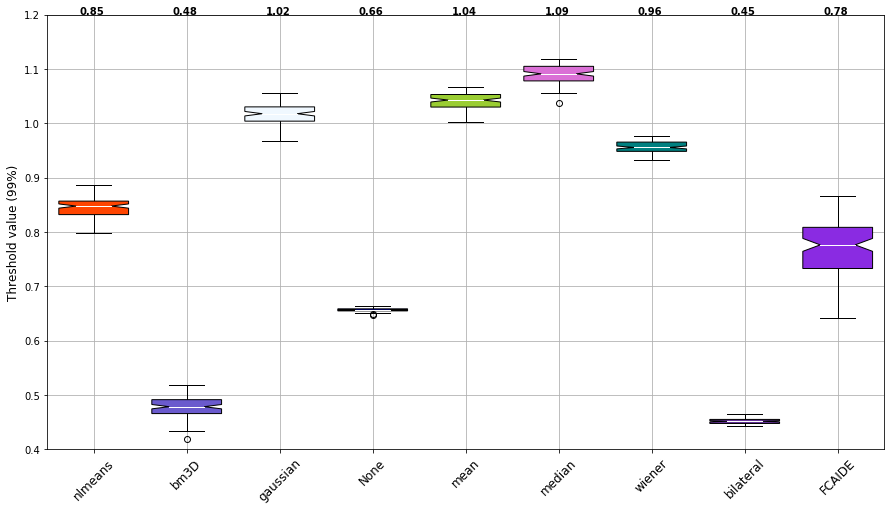

In [56]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
new_color_index = np.append(colors_index,10)
names[3] = 'None'
for i in range(0, t.shape[0]):
    c = color_names[new_color_index[i]]
    ax.boxplot(t[i,:], 
                positions = [i+1],
                patch_artist=True,
                notch = True,
                boxprops=dict(facecolor=c, color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(color='black', markeredgecolor='black'),
                medianprops=dict(color='white'),
                widths = 0.75)
    ax.text(i+1-0.15, 1.2, 
             str('%.2f'%np.median(t[i,:])),
             color = 'black',
             fontweight = 'black')


ax.set_xticklabels(names, rotation=45, fontsize=12)
ax.set_ylim(0.4, 1.2)
ax.set_ylabel('Threshold value (99%)', fontsize=12)
ax.grid()

## Choosing a fix threshold for each method

In [85]:
th_ops = [0.16, 0.09, 0.18, -0.10, 0.11, 0.10, 0.04, 0.09, 0.21]

In [96]:
bg = np.zeros((sg_eff.shape[2], sg_eff.shape[0]))
for filter_index in range(0, sg_eff.shape[2]):
    for image_number in range(0, sg_eff.shape[0]):
        x = bg_eff[image_number, :, filter_index]
        y = thresholds[image_number, :, filter_index]
        f_yx = interp1d(y, x)
        bg[filter_index, image_number] = f_yx(th_ops[filter_index])

In [99]:
bg.mean(axis=1)


array([0.67637126, 0.66141987, 0.68497674, 0.29369072, 0.61298342,
       0.61497323, 0.51937899, 0.60737056, 0.77968361])

In [100]:
bg.std(axis=1)

array([0.00781097, 0.01423483, 0.00529431, 0.00086305, 0.00399782,
       0.00350502, 0.00181103, 0.00350189, 0.02002135])